In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
torch.manual_seed(0)

# Define the Pareto front.
nadir = 0.0 * torch.ones(1, 2, **tkwargs)

pf = torch.tensor(
    [
        [0.3, 0.9],
        [0.5, 0.7],
        [0.6, 0.6],
        [0.7, 0.4],
        [0.95, 0.2],
    ],
    **tkwargs
)

weak_pf = torch.row_stack(
    [
        torch.tensor([nadir[0, 0], pf[0, 1]], **tkwargs),
        pf,
        torch.tensor([pf[-1, 0], nadir[0, 1]], **tkwargs),
    ]
)

# Rejection sampling for the points.
num_samples = 200

u = torch.zeros(num_samples, 2, **tkwargs)
num_gen = 0
while num_gen < num_samples:
    sample = 1.1 * torch.rand(1, 2, **tkwargs) - 0.1
    aug_pf = torch.row_stack([pf, sample])
    if not is_non_dominated(aug_pf)[-1]:
        u[num_gen, :] = sample
        num_gen += 1

# Polar parametrization.
num_weights = 15
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
s_fn = LengthScalarization(weights=weights, ref_points=nadir)
lengths = s_fn(pf).max(dim=0).values

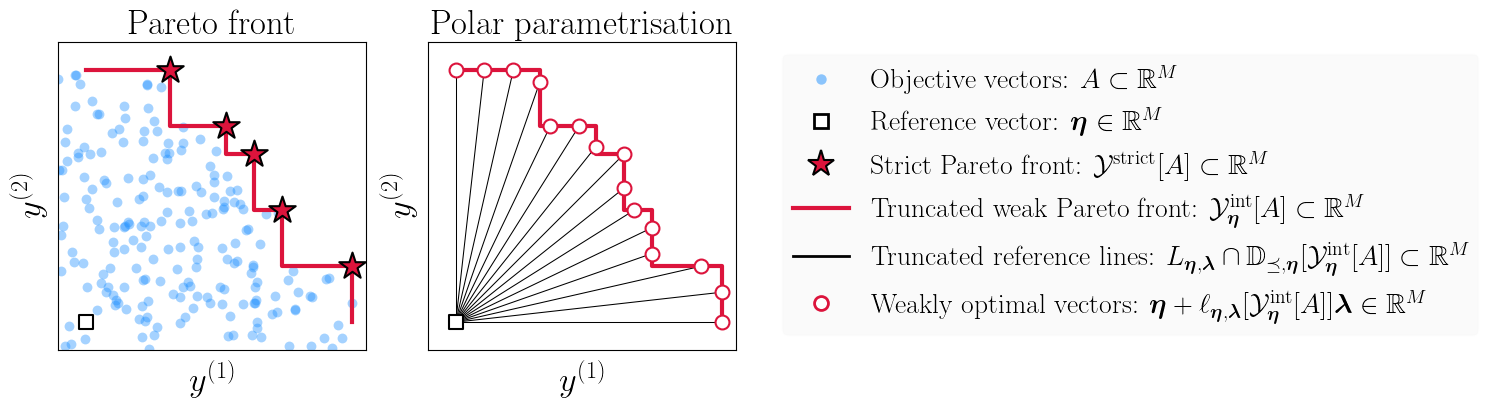

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8.75, 4))

for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    ax.step(
        weak_pf[:, 0],
        weak_pf[:, 1],
        color="crimson",
        linestyle="-",
        alpha=1,
        linewidth=3,
        zorder=4,
    )

    ax.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([-0.1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$y^{(1)}$", fontsize=25)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=25)
########################################################################################
# Pareto front.
ax = plt.subplot(1, 2, 1)
ax.scatter(
    pf[:, 0],
    pf[:, 1],
    color="crimson",
    marker="*",
    edgecolors="k",
    linewidth=1.5,
    s=400,
    zorder=5,
)
ax.scatter(u[:, 0], u[:, 1], color="dodgerblue", alpha=0.4, zorder=1, linewidth=0, s=50)
ax.set_title("Pareto front", fontsize=25)
########################################################################################
# Polar parametrization.
ax = plt.subplot(1, 2, 2)
for i, w in enumerate(weights):
    line_i = nadir + lengths[i] * t * w
    ax.plot(line_i[:, 0], line_i[:, 1], color="k", alpha=1, linewidth=0.75)
    ax.scatter(
        line_i[-1, 0],
        line_i[-1, 1],
        color="w",
        edgecolors="crimson",
        linewidth=1.5,
        s=100,
        zorder=5,
        alpha=1,
    )
ax.set_title("Polar parametrisation", fontsize=25)
########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

blue_circle = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    marker=".",
    linestyle="None",
    markersize=15,
    markeredgecolor="None",
    markeredgewidth=2,
    alpha=0.5,
    label=r"Objective vectors: $A \subset \mathbb{R}^M$",
)

red_star = mlines.Line2D(
    [],
    [],
    color="crimson",
    marker="*",
    linestyle="None",
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=1.5,
    label=r"Strict Pareto front: $\mathcal{Y}^{\text{strict}}[A] \subset \mathbb{R}^M$",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Truncated weak Pareto front: $\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[A] \subset \mathbb{R}^M$",
)

black_line = mlines.Line2D(
    [],
    [],
    color="k",
    linestyle="-",
    linewidth=2,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Truncated reference lines: $L_{\boldsymbol{\eta}, \boldsymbol{\lambda}} \cap \mathbb{D}_{\preceq, \boldsymbol{\eta}}[\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[A]] \subset \mathbb{R}^M$",
)

red_circle = mlines.Line2D(
    [],
    [],
    color="w",
    marker=".",
    linestyle="None",
    linewidth=1,
    markersize=20,
    markeredgecolor="crimson",
    markeredgewidth=2,
    label=r"Weakly optimal vectors: $\boldsymbol{\eta} + \ell_{\boldsymbol{\eta}, \boldsymbol{\lambda}}[\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[A]] \boldsymbol{\lambda} \in \mathbb{R}^M$",
)


axes[1].legend(
    handles=[blue_circle, white_square, red_star, red_line, black_line, red_circle],
    ncol=1,
    fontsize=20,
    loc=(1.15, 0.05),
    facecolor="k",
    framealpha=0.02,
)


plt.show()